# Training on balanced articles

Now I have trained, again, a logistic regression model to predict the probability of an article belongs to the each one of eight main major fields from the platform Currículo Lattes. But at this time I balanced the data so the amount of articles belonging to each field is almost the same.

At the end we got **an accuracy of 73%** on guessing the correct major field of the test data.

- [Encoding target](#Encoding-target)
- [Train and test split](#Train-and-test-split)
- [Encoding articles titles](#Encoding-articles-titles)
- [Training](#Training)
- [Evaluating](#Evaluating)
- [Evaluating the second option](#Evaluating-the-second-option)

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

In [163]:
# Reading the already cleaned data from researchers and its articles
with open('data/articles_and_fields_cleaned_df.pickle', 'rb') as f:
    articles_and_fields_df = pickle.load(f)

print('Shape:', articles_and_fields_df.shape)
articles_and_fields_df.head()

Shape: (14537, 4)


,researcher_name,researcher_lattes_id,researcher_major_field,article_title
0,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Níveis das vitaminas A e E em dietas de frango...
1,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Adição de bentonita sódica como adsorvente de ...
2,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Níveis de substituição da DL-metionina pela me...
3,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Enzimas de função hepática na aflatoxicose agu...
4,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,"Efeitos de Níveis das VitaminasA, E, Piridoxin..."


In [164]:
# Getting a balanced amount of articles based on the amount of the field with less articles
num_samples = articles_and_fields_df['researcher_major_field'].value_counts().min()
balanced_articles_df = articles_and_fields_df.groupby('researcher_major_field',
                                                      as_index=False).apply(lambda x: x.sample(n=num_samples))
balanced_articles_df.reset_index(drop=True, inplace=True)
balanced_articles_df['researcher_major_field'].value_counts()

Ciências Agrárias              1164
Ciências Biológicas            1164
Ciências Exatas e da Terra     1164
Ciências Humanas               1164
Ciências Sociais Aplicadas     1164
Ciências da Saúde              1164
Engenharias                    1164
Lingüística, Letras e Artes    1164
Name: researcher_major_field, dtype: int64

## Encoding target

In [165]:
# Creating an label encoder to transform the target variable to a format acceptable by the logistic regression model
le = LabelEncoder()
balanced_articles_df['labeled_major_field'] = le.fit_transform(balanced_articles_df['researcher_major_field'])

In [166]:
# The classes represented
le.classes_

array(['Ciências Agrárias', 'Ciências Biológicas',
       'Ciências Exatas e da Terra', 'Ciências Humanas',
       'Ciências Sociais Aplicadas', 'Ciências da Saúde', 'Engenharias',
       'Lingüística, Letras e Artes'], dtype=object)

## Train and test split

In [183]:
# Splitting the data in train and test
test_size = 0.1

X = balanced_articles_df.copy()
y = balanced_articles_df['labeled_major_field'].copy()

X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

print('Train articles:', X_train_.shape[0])
print('Test articles:', X_test_.shape[0])

Train articles: 8380
Test articles: 932


In [184]:
# Checking if the train data is balanced
X_train_['researcher_major_field'].value_counts(normalize=True) * 100

Ciências Humanas               12.541766
Ciências Exatas e da Terra     12.529833
Ciências Agrárias              12.517900
Ciências da Saúde              12.494033
Ciências Biológicas            12.494033
Engenharias                    12.482100
Ciências Sociais Aplicadas     12.470167
Lingüística, Letras e Artes    12.470167
Name: researcher_major_field, dtype: float64

## Encoding articles titles

In [185]:
# Using the count vectorizer, with binary format, to represent the articles titles
vec = CountVectorizer(binary=True, strip_accents='unicode', stop_words=['english', 'portuguese'],
                      min_df=2, max_df=0.13, dtype=np.int8)

In [186]:
# Encoding the train data and getting the generated features
X_train = vec.fit_transform(X_train_['article_title']).toarray()
features = vec.get_feature_names_out()
print('Shape:', X_train.shape)

Shape: (8380, 8232)


In [187]:
# Encoding the test data
X_test = vec.transform(X_test_['article_title'])
print('Shape:', X_test.shape)

Shape: (932, 8232)


## Training

In [188]:
%%time

# Training the logistic regression model
model = LogisticRegression(random_state=0, max_iter=200)
model.fit(X_train, y_train)

CPU times: total: 6min 33s
Wall time: 1min 1s


LogisticRegression(max_iter=200, random_state=0)

## Evaluating

In [189]:
# Evaluating the accuracy of the model on the train and test data
print('Train score:', model.score(X_train, y_train))
print('Test score:', model.score(X_test, y_test))

Train score: 0.9576372315035799
Test score: 0.73068669527897


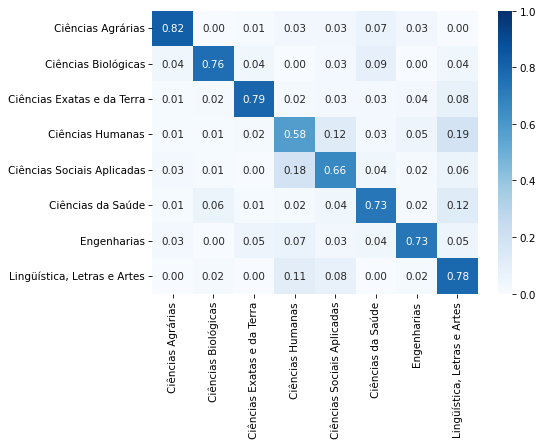

In [190]:
# Confusion matrix to evaluate the model on the specific fields
cm = confusion_matrix(y_test, model.predict(X_test))
cm_df = pd.DataFrame(cm, columns=le.classes_, index=le.classes_)
cm_df_normalized = cm_df.div(cm_df.sum(axis=1), axis=0)

plt.figure(figsize=(7, 5), dpi=75)
sns.heatmap(cm_df_normalized, cmap='Blues', vmax=1.0, annot=True, fmt='.02f');

---

Interesting to notice that not necessarily the fields with less articles in the original data had better accuracy now that the data is balanced.

---

### Evaluating the second option

I am interest in knowing the accuracy of the model if we consider also the second most likely field predicted for the articles.

In [191]:
# Functions to get the first and second most likely field
first = lambda array: array.argmax()
second = lambda array: array[0].argsort()[::-1][1]

In [192]:
# Filling the train data with the predicted fields
X_train_.reset_index(drop=True, inplace=True)
X_train_['first_field_predicted'] = None
X_train_['second_field_predicted'] = None
for i, row in X_train_.iterrows():
    predicted_proba = model.predict_proba([X_train[i, :]])
    X_train_.at[i, 'first_field_predicted'] = first(predicted_proba)
    X_train_.at[i, 'second_field_predicted'] = second(predicted_proba)

# Accuracy of first or second field predicted on train data
first_field_right = X_train_['labeled_major_field'] == X_train_['first_field_predicted']
second_field_right = X_train_['labeled_major_field'] == X_train_['second_field_predicted']
print('Accuracy of first or second field predicted on train data:',
      (first_field_right | second_field_right).sum() / X_train_.shape[0])

Accuracy of first or second field predicted on train data: 0.9867541766109785


In [193]:
# Filling the test data with the predicted fields
X_test_.reset_index(drop=True, inplace=True)
X_test_['first_field_predicted'] = None
X_test_['second_field_predicted'] = None
for i, row in X_test_.iterrows():
    X_test_.at[i, 'first_field_predicted'] = first(model.predict_proba(X_test[i]))
    X_test_.at[i, 'second_field_predicted'] = second(model.predict_proba(X_test[i]))

# Accuracy of first or second field predicted on test data
first_field_right = X_test_['labeled_major_field'] == X_test_['first_field_predicted']
second_field_right = X_test_['labeled_major_field'] == X_test_['second_field_predicted']
print('Accuracy of first or second field predicted on test data:',
      (first_field_right | second_field_right).sum() / X_test_.shape[0])

Accuracy of first or second field predicted on test data: 0.8444206008583691
